In [3]:
dataset_path_name  ='superblue1'

In [ ]:
# read superblue1/superblue1.aux
with open(dataset_path_name + '/' + dataset_path_name + '.aux', 'r') as f:
    lines = f.readlines()
    for line in lines:
        if 'nrows' in line:
            nrows = int(line.split('=')[1])
        if 'ncols' in line:
            ncols = int(line.split('=')[1])
        if 'xllcorner' in line:
            xllcorner = float(line.split('=')[1])
        if 'yllcorner' in line:
            yllcorner = float(line.split('=')[1])
        if 'cellsize' in line:
            cellsize = float(line.split('=')[1])
        if 'NODATA_value' in line:
            NODATA_value = int(line.split('=')[1])

In [ ]:
# read superblue1/superblue1.nodes
nodes = []
with open(dataset_path_name + '/' + dataset_path_name + '.nodes') as f:
    # ignore the first four lines
    # then there will be a line "NumNodes      :  847441", read the NumNodes
    # then there will be a line "NumTerminals  :  82339", read the NumTerminals
    # then there will be an empty line, followed by NumNodes lines of nodes. For each node, it will be 'ObjName width height movetype', like '             o0             5             9', some of movetype will be empty.
    for i in range(4):
        f.readline()
    num_nodes = int(f.readline().split()[-1])
    num_terminals = int(f.readline().split()[-1])
    f.readline()
    for i in range(num_nodes):
        node = f.readline().split()
        nodes.append(node)
    assert len(nodes) == num_nodes
    assert num_terminals == 0
print('nodes:', len(nodes))
print(nodes[:5])

nodes: 847448
['UCLA nodes 1.0', '# Created  :  Mar 19 2011', '# User     :  Gi-Joon Nam & Natarajan Viswanathan at IBM Research, Austin ({gnam, nviswan}@us.ibm.com)', '', 'NumNodes      :  847441']


In [10]:
import numpy as np
import matplotlib.pyplot as plt
import xgi

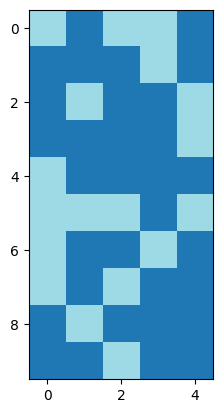

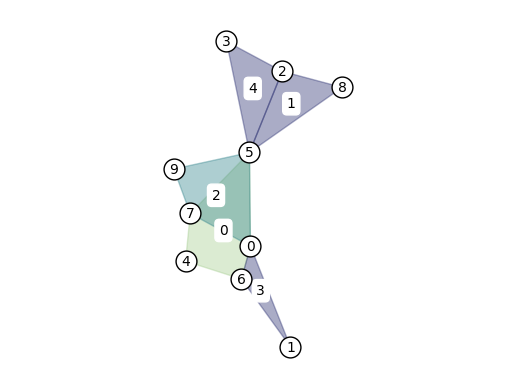

initial cutsize: 4
final cutsize: 4
[0 1 0 1 1 1 1 1 1 0]


In [ ]:
# implement Fiduccia-Mattheyses algorithm
# hypergraph G is a matrix, each row is a node, each column is a hyperedge, G[vi][ej] = True means node vi is in hyperedge ej
def generate_hypergraph(num_nodes, num_hyperedges, p = 0.5):
    G = np.zeros((num_nodes, num_hyperedges), dtype=bool)
    # random generate G
    np.random.seed(17)
    for i in range(num_nodes):
        for j in range(num_hyperedges):
            if np.random.rand() < p:
                G[i][j] = True
    return G

# convert a matrix format hypergraph to a vertex-edge format hypergraph
def matrix_to_veform(G):
    num_nodes, num_hyperedges = G.shape
    vertices = [vi for vi in range(num_nodes)]
    edges = [[vi for vi in range(num_nodes) if G[vi][ej] == True] for ej in range(num_hyperedges)]
    return vertices, edges

# convert a vertex-edge format hypergraph to a matrix format hypergraph
def veform_to_matrix(vertices, edges):
    num_nodes = len(vertices)
    num_hyperedges = len(edges)
    G = np.zeros((num_nodes, num_hyperedges), dtype=bool)
    for ej in range(num_hyperedges):
        for vi in edges[ej]:
            G[vi][ej] = True

def visualize_hypergraph(G):
    plt.imshow(G, cmap='tab20')
    plt.show()

    H = xgi.Hypergraph()
    vertices, edges = matrix_to_veform(G)
    H.add_nodes_from(vertices)
    H.add_edges_from(edges)
    xgi.draw(H, node_labels=True, node_size=15, hyperedge_labels=True)
    plt.show()

G = generate_hypergraph(10, 5, 0.3)
visualize_hypergraph(G)

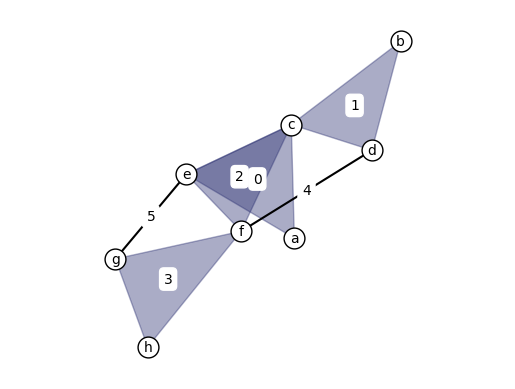

left_bucket
------
 max_gain: 2
gain list
gain: -6 -> 
gain: 0 -> a -> 
gain: 1 -> d -> c -> 
gain: 2 -> g -> 
cell list
a (pre: None suc: None) | c (pre: d suc: None) | d (pre: None suc: c) | g (pre: None suc: None) | 
right_bucket
------
 max_gain: 2
gain list
gain: -6 -> 
gain: 1 -> f -> b -> 
gain: 2 -> e -> 
gain: 0 -> h -> 
cell list
b (pre: f suc: None) | e (pre: None suc: None) | f (pre: None suc: b) | h (pre: None suc: None) | 
 iter =  0
move  e
cut_size after move: 4
partition: {'a': 0, 'b': 1, 'c': 0, 'd': 0, 'e': 0, 'f': 1, 'g': 0, 'h': 1}
left_bucket
------
 max_gain: 1
gain list
gain: -6 -> 
gain: 1 -> d -> 
gain: -1 -> c -> a -> 
gain: 0 -> g -> 
cell list
d (pre: None suc: None) | a (pre: c suc: None) | c (pre: None suc: a) | g (pre: None suc: None) | 
right_bucket
------
 max_gain: 2
gain list
gain: -6 -> 
gain: 1 -> b -> 
gain: 0 -> h -> 
gain: 2 -> f -> 
cell list
b (pre: None suc: None) | h (pre: None suc: None) | f (pre: None suc: None) | 
 iter =  1
move  d
cut_s

{'a': 1, 'b': 0, 'c': 1, 'd': 1, 'e': 0, 'f': 0, 'g': 1, 'h': 0}

In [82]:
class Node:
    def __init__(self, name, pre = None, suc = None, size = 1, locked = False, gain = 0):
        self.name = name
        self.pre = pre
        self.suc = suc
        self.size = size
        self.locked = locked
        self.gain = gain
    def set_pre(self, pre):
        self.pre = pre
    def set_suc(self, suc):
        self.suc = suc
    def lock(self):
        self.locked = True

class Bucket:
    def __init__(self, pmax):
        self.pmax = pmax
        self.max_gain = -pmax
        # cells maps name to Node object
        self.cells = {}
        # gains maps gain value to a linked list of Node objects
        self.gains = { -pmax: None}
        # size of the part
        self.size = 0

    def insert_vertex(self, name, gain, size = 1):
        if gain not in self.gains:
            self.gains[gain] = Node(name, size=size, gain=gain)
            self.cells[name] = self.gains[gain]
        else:
            node = Node(name, size=size, gain=gain)
            node.set_suc(self.gains[gain])
            self.gains[gain].set_pre(node)
            self.gains[gain] = node
            self.cells[name] = node
        if gain > self.max_gain:
            self.max_gain = gain
        self.size += size

    def remove_vertex(self, name):
        node = self.cells[name]
        gain = node.gain
        self.size -= node.size
        if node.pre and node.suc:
            node.pre.set_suc(node.suc)
            node.suc.set_pre(node.pre)
        elif node.pre:
            node.pre.set_suc(None)
        elif node.suc:
            self.gains[gain] = node.suc
            node.suc.set_pre(None)
        else:
            del self.gains[gain]
            if gain == self.max_gain:
                if len(self.gains) == 0:
                    self.max_gain = -self.pmax
                else:
                    self.max_gain = max(self.gains.keys())
                # self.max_gain = max(self.gains.keys())
        del self.cells[name]

    def update_gain(self, name, new_gain):
        size = self.cells[name].size
        self.remove_vertex(name)
        self.insert_vertex(name, new_gain, size)

    def add_size_after_move_in(self, size):
        self.size += size
    
    def get_max_gain_vertex(self):
        if self.size == 0:
            return None
        return self.gains[self.max_gain]
    
    def get_size(self):
        return self.size
    
    def dump(self):
        print('------\n max_gain:', self.max_gain)
        print('gain list')
        for gain in self.gains:
            print('gain:', gain, end=' -> ')
            node = self.gains[gain]
            while node:
                print(node.name, end=' -> ')
                node = node.suc
            print()
        print('cell list')
        for name in self.cells:
            print(name, end=' ')
            node = self.cells[name]
            print('(pre:', node.pre.name if node.pre else None, end=' ')
            print('suc:', node.suc.name if node.suc else None, end=') | ')
        print()

class Hypergraph:
    def __init__(self, vertices, edges, sizes = None):
        self.num_vertices = len(vertices)
        self.num_edges = len(edges)
        # vertex = ['a', 'b', 'c', ...]
        self.vertices = vertices
        # edges = [['a', 'b', 'c'], ['b', 'c', 'd'], ...]
        self.edges = edges
        # sizes = [size of vertex a, size of vertex b, ...]
        if sizes:
            self.sizes = sizes
        else:
            self.sizes = {v:1 for v in vertices}
        self.max_size = max(self.sizes.values())
        self.balance_size = sum(self.sizes.values()) // 2
        # G = {'a':[True, False, ...], 'b':[True, True, ...], ...}
        self.G = {}
        for v in self.vertices:
            self.G[v] = [False for ej in range(self.num_edges)]
        for ej in range(self.num_edges):
            for v in edges[ej]:
                self.G[v][ej] = True

    def visualize_hypergraph(self):
        H = xgi.Hypergraph()
        H.add_nodes_from(self.vertices)
        H.add_edges_from(self.edges)
        xgi.draw(H, node_labels=True, node_size=15, hyperedge_labels=True)
        plt.show()
    
    # k is the maximum allowed unbalance vertices
    def Fiduccia_Mattheyses(self, k = 1, max_loops = 100):
        # randomly partition G into two parts
        # init_part_vector = np.random.randint(0, 2, self.num_vertices)
        # for test
        init_part_vector = [0, 1, 0, 0, 1, 1, 0, 1]
        # initialize the partiton
        partition = {self.vertices[i]:init_part_vector[i] for i in range(self.num_vertices)}
        locked_vertices = {v:False for v in self.vertices}
        
        # for each edge, there are three cases:
        # 1. all vertices are in the same part
        # 2. only one vertex is in the other part
        # 3. two or more vertices are in each part
        
        # count the number of vertices in each part for given edge and partition
        def count_edge_partition(ej, partition):
            count = [0, 0]
            for v in self.edges[ej]:
                count[partition[v]] += 1
                # only 0, 1 have meanings
                if count >= [4,4]:
                    break
            return count

        edge_count = [count_edge_partition(ej, partition) for ej in range(self.num_edges)]
        # calculate the gain of each vertex
        init_gains = {v:0 for v in self.vertices}
        for v in self.vertices:
            for ej in range(self.num_edges):
                if self.G[v][ej]:
                    if edge_count[ej][partition[v]] == 1:
                        init_gains[v] += 1
                    if edge_count[ej][1-partition[v]] == 0:
                        init_gains[v] -= 1

        # initialize two buckets
        buckets = [Bucket(self.num_edges), Bucket(self.num_edges)]
        for v in self.vertices:
            buckets[partition[v]].insert_vertex(v, init_gains[v], self.sizes[v])
        # visualize_hypergraph()
        print('left_bucket')
        buckets[0].dump()
        print('right_bucket')
        buckets[1].dump()

        # calculate current cutsize
        cut_size = 0
        for ej in range(self.num_edges):
            if edge_count[ej][0] > 0 and edge_count[ej][1] > 0:
                cut_size += 1
        # compare and record mini partition
        min_cut_size = cut_size
        min_cut_partition = partition


        # main loop
        for iter in range(max_loops):
            # find max gain vertices of each part, if None then the burcket is empty
            max_gain_vertices = [buckets[0].get_max_gain_vertex(), buckets[1].get_max_gain_vertex()]
            # case 1. both buckets are empty, finished
            # case 2. only one can move, check balance condition, if satisfied, move it, otherwise finished
            # case 3. both can move, check balance condition, if only one satisfies, move it, otherwise finished
            vertex_to_move = None

            vertex_can_move = [max_gain_vertices[0] is not None, max_gain_vertices[1] is not None]
            # vertex can move if and only if it's not None, and it satisfies the balance condition
            for i in range(2):
                if vertex_can_move[i]:
                    if abs(buckets[i].get_size() - max_gain_vertices[i].size - self.balance_size) > k*self.max_size:
                        vertex_can_move[i] = False
            if not vertex_can_move[0] and not vertex_can_move[1]:
                break
            elif not vertex_can_move[0]:
                vertex_to_move = max_gain_vertices[1]
            elif not vertex_can_move[1]:
                vertex_to_move = max_gain_vertices[0]
            else:
                if max_gain_vertices[0].gain > max_gain_vertices[1].gain:
                    vertex_to_move = max_gain_vertices[0]
                elif max_gain_vertices[0].gain < max_gain_vertices[1].gain:
                    vertex_to_move = max_gain_vertices[1]
                elif max_gain_vertices[0].name < max_gain_vertices[1].name:
                    vertex_to_move = max_gain_vertices[0]
                else:
                    vertex_to_move = max_gain_vertices[1]
            
            # If we can move some vertex, then move it and update all of its neibors' gain
            if vertex_to_move:
                buckets[partition[vertex_to_move.name]].remove_vertex(vertex_to_move.name)
                locked_vertices[vertex_to_move.name] = True
                from_part = partition[vertex_to_move.name]
                to_part = 1 - from_part

                for ej in range(self.num_edges):
                    if self.G[vertex_to_move.name][ej]:
                        # this edge contains the vertex to move, if it is critical, update the gain of its unlocked(exists in either bucket) vertices
                        edge_count = count_edge_partition(ej, partition)
                        if edge_count[to_part] == 0:
                            # increase the gain of all the unlocked vertices on this edge
                            for v in self.edges[ej]:
                                if not locked_vertices[v]:
                                    buckets[partition[v]].update_gain(v, buckets[partition[v]].cells[v].gain + 1)
                        elif edge_count[to_part] == 1:
                            # decrease the gain of all the unlocked vertices on this edge in to_part
                            for v in self.edges[ej]:
                                if partition[v] == to_part and not locked_vertices[v]:
                                    buckets[partition[v]].update_gain(v, buckets[partition[v]].cells[v].gain - 1)
                        edge_count[from_part] -= 1
                        edge_count[to_part] += 1
                        if edge_count[from_part] == 0:
                            # decrease the gain of all the unlocked vertices on this edge
                            for v in self.edges[ej]:
                                if not locked_vertices[v]:
                                    buckets[partition[v]].update_gain(v, buckets[partition[v]].cells[v].gain - 1)
                        elif edge_count[from_part] == 1:
                            # increase the gain of all the unlocked vertices on this edge in from_part
                            for v in self.edges[ej]:
                                if partition[v] == from_part and not locked_vertices[v]:
                                    buckets[partition[v]].update_gain(v, buckets[partition[v]].cells[v].gain + 1)

                partition[vertex_to_move.name] = 1 - partition[vertex_to_move.name]
                buckets[partition[vertex_to_move.name]].add_size_after_move_in(vertex_to_move.size)

            # calculate current cutsize
            cut_size = 0
            edge_count = [count_edge_partition(ej, partition) for ej in range(self.num_edges)]
            for ej in range(self.num_edges):
                if edge_count[ej][0] > 0 and edge_count[ej][1] > 0:
                    cut_size += 1
            # compare and record mini partition
            if min_cut_size > cut_size:
                min_cut_size = cut_size
                min_cut_partition = partition

            print("======\n iter = ", iter)
            print("move ", vertex_to_move.name)
            print('cut_size after move:', cut_size)
            print('partition:', partition)  
            print('left_bucket')
            buckets[0].dump()
            print('right_bucket')
            buckets[1].dump()
        print('min_cut_size:', min_cut_size)
        print('min_cut_partition:', min_cut_partition)
        return min_cut_partition
        




v = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']
e = [['a', 'c', 'e'], ['b', 'c', 'd'], ['c', 'e', 'f'], ['h', 'f', 'g'], ['d', 'f'], ['g', 'e']]
G = Hypergraph(v, e)
G.visualize_hypergraph()
G.Fiduccia_Mattheyses()

